In [1]:
import os
import numpy as np
from geopy import distance
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
from tqdm import tqdm
from datetime import datetime
from stack_image import StackedImageDataset
from model import StreetViewNetViT
from args import args

data_path = '../data/640x640/'

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device {device}")

writer = SummaryWriter()

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),

    # Because I am not sure that it will affect StackedImageDataset, so I won't touch it.
    # I think that these 2 lines will affect very much
    # adding flipping, affine pictures into dataset
    # transforms.RandomHorizontalFlip(),
    # transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.8, 1.2)),
    
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])   
])

c:\Users\ASUS\Documents\GitHub\Machine-Learning-Final-Project\code\model.py:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  vit = torch.load('./trained_models/vit.pth')


Using device cpu


In [32]:
dataset = StackedImageDataset(data_path, transform=transform)
train_size = int((1 - args.val_ratio) * len(dataset))
val_size = len(dataset) - train_size
# train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])


model = torch.load('./trained_models/street_view_model_10-25_2.pth')

C:\Users\ASUS\AppData\Local\Temp\ipykernel_19068\1079671287.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load('./trained_models/street_view_model_10-25_

In [33]:
from custom_loss import CustomLoss
val_loss = 0
predict_outputs = []
val_labels = []
loss_fn = CustomLoss()
for images, labels in DataLoader(dataset, batch_size=args.batch_size):
    images, labels = images.to(device), labels.to(device)
    outputs = model(images)
    predict_outputs.append(outputs.detach().numpy())
    val_labels.append(labels.detach().numpy())
    val_loss += loss_fn(outputs, labels).item()

In [34]:
len(predict_outputs[0])

4

In [35]:
import pandas as pd
df_predict_outputs = pd.DataFrame(np.vstack(predict_outputs))
df_val_labels = pd.DataFrame(np.vstack(val_labels))

In [36]:
df_predict_outputs.tail()

,0,1,2,3,4,5,6,7,8,9,...,104,105,106,107,108,109,110,111,112,113
1912,23.865347,120.434273,-5.372008,-5.382589,-1.307020,-0.280403,-5.336271,-5.257498,-5.293316,-5.431919,...,0.151718,-0.968427,-5.235986,-5.267796,-5.326613,-5.335068,-4.902104,-5.282070,-1.125772,-5.233932
1913,24.823462,121.165955,-5.091512,-5.064624,-2.077583,-0.228793,-5.031454,-4.989345,-5.009078,-5.130952,...,0.702585,-0.526139,-5.020702,-4.975674,-4.980644,-5.026370,-4.598496,-4.915915,-1.031153,-4.908133
1914,23.883190,120.431618,-5.464688,-5.487628,-0.865505,-0.267268,-5.441691,-5.331491,-5.388259,-5.529555,...,-0.187396,-1.227825,-5.298638,-5.369422,-5.447221,-5.440475,-5.011284,-5.421997,-1.155866,-5.344282
1915,23.868004,120.421753,-5.386581,-5.404579,-1.116285,-0.235704,-5.359011,-5.251047,-5.308463,-5.446078,...,-0.007926,-1.105131,-5.243001,-5.288845,-5.347236,-5.349713,-4.918996,-5.312028,-1.128577,-5.251812
1916,24.811947,121.179131,-5.070316,-5.031184,-2.372877,-0.240545,-4.985263,-4.989227,-4.974420,-5.102634,...,0.933164,-0.334318,-5.005881,-4.938948,-4.934700,-4.991569,-4.570401,-4.854222,-0.991061,-4.871213


In [37]:
df_val_labels.tail()

,0,1
1912,22.733900,121.136597
1913,22.709400,120.351898
1914,23.097700,120.155098
1915,22.698099,121.080704
1916,22.763201,121.060402


In [38]:
difference = df_predict_outputs - df_val_labels.iloc[:, :2]

In [39]:
print(difference)

           0         1    2    3    4    5    6    7    8    9    ...  104  \
0     0.735050  0.376778  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...  NaN   
1    -0.208096 -0.701355  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...  NaN   
2     1.374666 -0.072044  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...  NaN   
3     0.691999  0.464920  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...  NaN   
4     1.869246  0.055412  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...  NaN   
...        ...       ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
1912  1.131447 -0.702324  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...  NaN   
1913  2.114061  0.814056  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...  NaN   
1914  0.785490  0.276520  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...  NaN   
1915  1.169905 -0.658951  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...  NaN   
1916  2.048746  0.118729  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...  NaN   

      105  106  107  108  109  110  111  112  113  
0     NaN  

In [40]:
print(np.var(difference[0]))
print(np.var(difference[1]))

0.76258993
0.25538766


In [41]:
df_predict_outputs.shape

(1917, 114)

In [42]:
import numpy as np

# 生成 32 個在 20 到 25.5 之間的隨機數
random_values_1 = np.random.uniform(20, 25.5, 1917)
random_values_2 = np.random.uniform(120, 122, 1917)

random_values_1 = df_val_labels[0] - random_values_1
random_values_2 = df_val_labels[1] - random_values_2

print(np.var(random_values_1))

print(np.var(random_values_2))

3.2244062343364703
0.5474076667660948


In [43]:
x = np.arange(1, 1 + difference.shape[0])
print(x)

[   1    2    3 ... 1915 1916 1917]


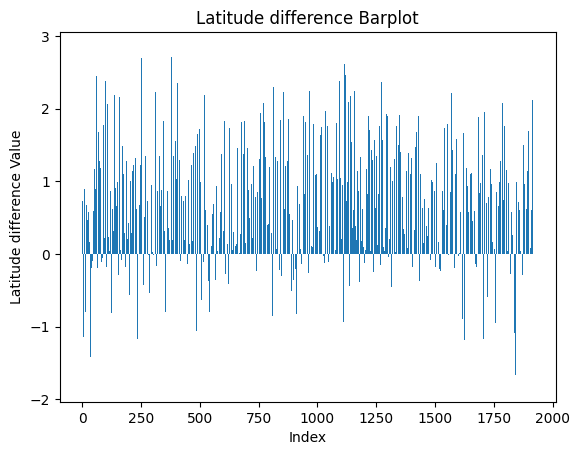

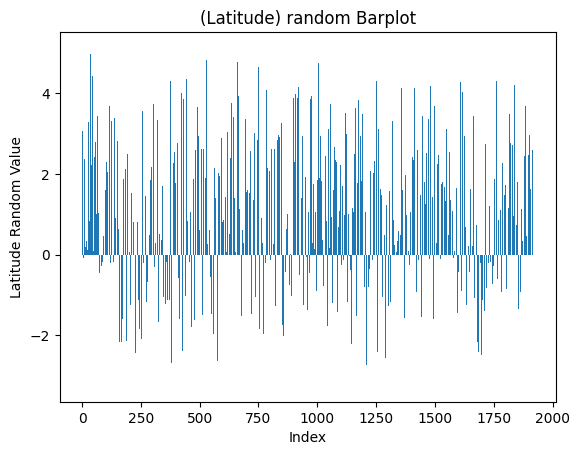

In [44]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

plt.bar(x, difference[0])

# 添加標題和標籤
plt.title('Latitude difference Barplot')
plt.xlabel('Index')
plt.ylabel('Latitude difference Value')

# 顯示圖表
plt.show()

plt.bar(x, random_values_1)

# 添加標題和標籤
plt.title('(Latitude) random Barplot')
plt.xlabel('Index')
plt.ylabel('Latitude Random Value')

# 顯示圖表
plt.show()

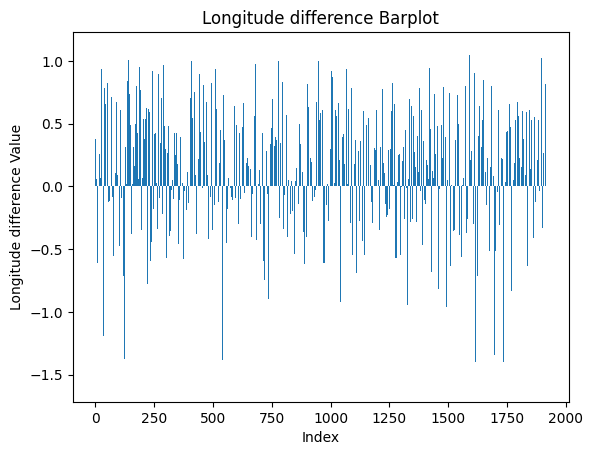

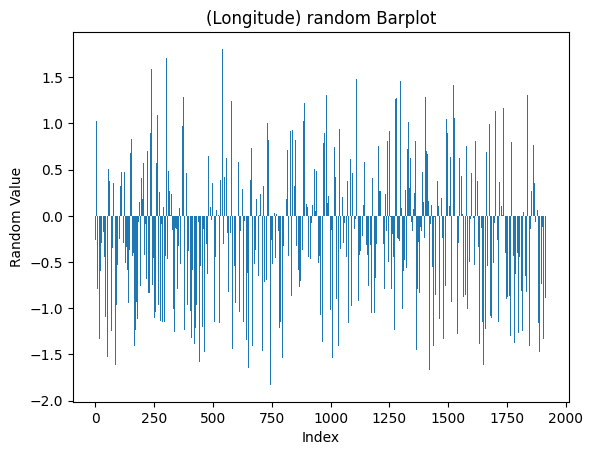

In [45]:
%matplotlib inline

plt.bar(x, difference[1])

# 添加標題和標籤
plt.title('Longitude difference Barplot')
plt.xlabel('Index')
plt.ylabel('Longitude difference Value')

# 顯示圖表
plt.show()

plt.bar(x, random_values_2)

# 添加標題和標籤
plt.title('(Longitude) random Barplot')
plt.xlabel('Index')
plt.ylabel('Random Value')

# 顯示圖表
plt.show()

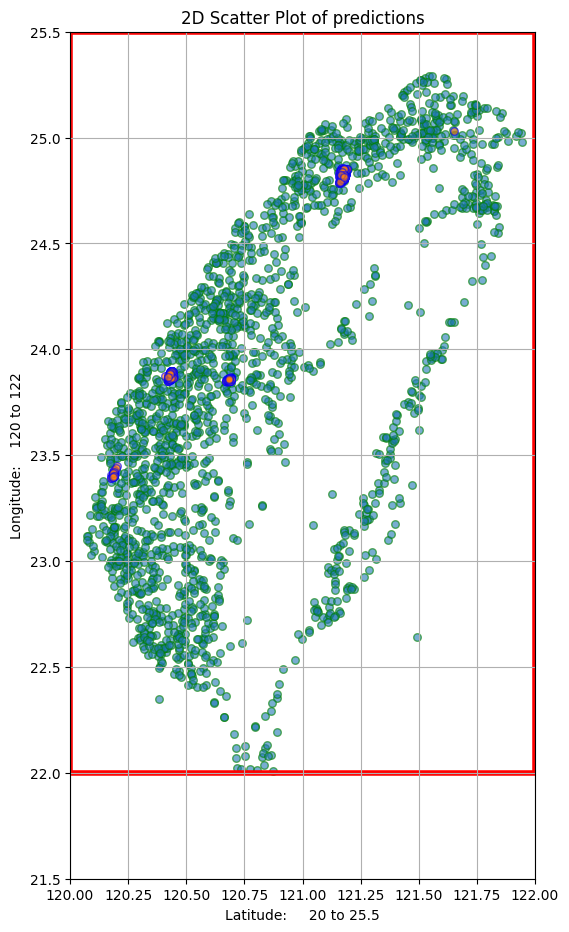

In [57]:
import matplotlib.patches as patches

plt.figure(figsize=(6, 11))

plt.scatter(df_val_labels[1], df_val_labels[0], alpha=0.6, edgecolors='g', s=30)
plt.scatter(df_predict_outputs[1], df_predict_outputs[0], alpha=0.6, edgecolors='b', s=30)

rectangle = patches.Rectangle((120, 22), 2, 3.5, linewidth=4, edgecolor='red', facecolor='none')
plt.gca().add_patch(rectangle)


plt.title('2D Scatter Plot of predictions')
plt.xlabel('Latitude:     20 to 25.5')
plt.ylabel('Longitude:    120 to 122')
plt.ylim(21.5, 25.5)
plt.xlim(120, 122)

plt.grid(True)
plt.show()